# Data Loading

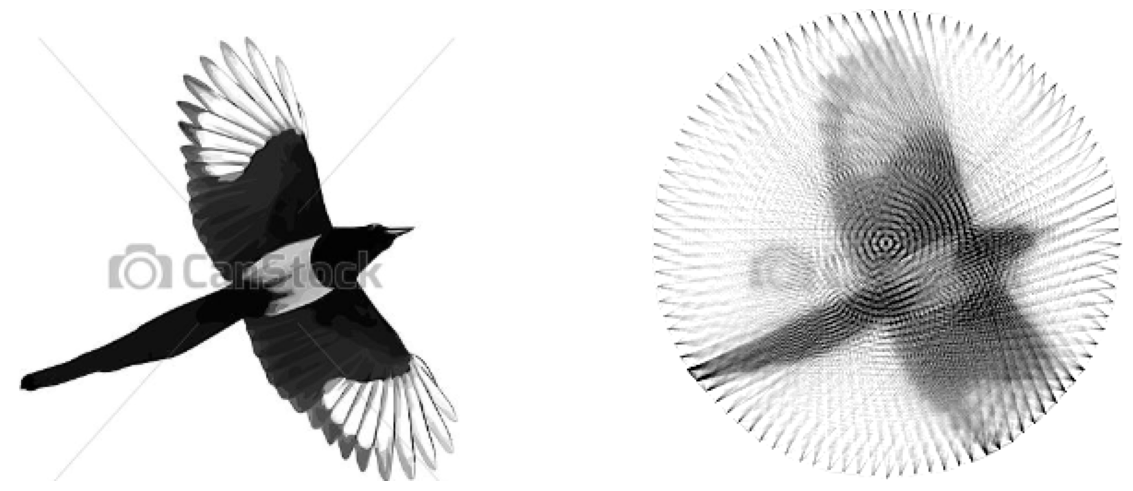

In [11]:
import os

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor
from typing import Tuple


class Config:
    DATASET_DIR = "/kaggle/input/stringart-ai-1000/stringart-dataset"
    UNET_PLOT_DIR= "/kaggle/working"
    

class StringArtDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

        self.images = []
        self.labels = []

        for img_path, label_path in self.file_list:
            img = np.array(imread(img_path))
            label = np.array(imread(label_path))

            self.images.append(to_tensor(img))
            self.labels.append(to_tensor(label))

        self.images = torch.stack(self.images)
        self.labels = torch.stack(self.labels)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


def load_data(input_dir: str, batch_size: int = 64) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """Load the dataset from the specified directory, split it into training, validation, and test sets,
    and return corresponding DataLoaders for each set.

    Parameters
    ----------
    input_dir : str
        The directory path containing the dataset. It should have a `metadata.csv` file and
        subdirectories `images` and `labels` containing the image and label files, respectively.
    batch_size : int, optional
        The batch size for the DataLoader. Default is 64.

    Returns
    -------
    tuple
        A tuple containing three `DataLoader` objects:
        - train_loader (DataLoader): The DataLoader for the training dataset.
        - validation_loader (DataLoader): The DataLoader for the validation dataset.
        - test_loader (DataLoader): The DataLoader for the test dataset.
    """

    df = pd.read_csv(os.path.join(input_dir, "metadata.csv"))
    samples = [
        (os.path.join(input_dir, "images", img_name), os.path.join(input_dir, "labels", label_name))
        for _, (img_name, label_name) in df.iterrows()
    ]

    train_data, temp_data = train_test_split(samples, test_size=0.3, random_state=42)
    validation_data, test_data = train_test_split(temp_data, test_size=0.1, random_state=42)

    train_loader = DataLoader(StringArtDataset(train_data), batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(StringArtDataset(validation_data), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(StringArtDataset(test_data), batch_size=batch_size, shuffle=False)

    return train_loader, validation_loader, test_loader



train_loader, validation_loader, test_loader = load_data(Config.DATASET_DIR, batch_size=16)

batch = next(iter(train_loader))
img, label = batch[0][0], batch[1][0]

image = img.cpu().numpy().transpose(1, 2, 0)
label = label.cpu().numpy().transpose(1, 2, 0)

fig, axs = plt.subplots(1, 2, figsize=[2 * 6.4, 4.8], constrained_layout=True)
cmap = "gray"

axs[0].imshow(image, cmap=cmap)
axs[0].set_axis_off()

axs[1].imshow(label, cmap=cmap)
axs[1].set_axis_off()

fig.show()


In [12]:
import torch
from torch import nn, optim

class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d, self).__init__()

        self.double_conv2d = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.double_conv2d(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.ModuleList(
            [
                DoubleConv2d(in_channels, 16),
                DoubleConv2d(16, 32),
                DoubleConv2d(32, 64),
                DoubleConv2d(64, 128),
                DoubleConv2d(128, 256),
            ]
        )

        self.decoder = nn.ModuleList(
            [
                DoubleConv2d(256, 128),
                DoubleConv2d(128, 64),
                DoubleConv2d(64, 32),
                DoubleConv2d(32, 16),
            ]
        )

        self.deconv = nn.ModuleList(
            [
                nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
                nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
                nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
                nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            ]
        )

        self.pool = nn.MaxPool2d((2, 2))
        self.last_layer_conv = nn.Conv2d(in_channels=16, out_channels=out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        stk = []
        for encoder in self.encoder:
            x = encoder(x)
            stk.append(x)
            x = self.pool(x)

        x = stk.pop(-1)
        for index in range(len(self.decoder)):
            encoder_output = stk.pop(-1)
            x = self.deconv[index](x)

            x = torch.cat([encoder_output, x], dim=1)
            x = self.decoder[index](x)

        return torch.sigmoid(self.last_layer_conv(x))

In [13]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=2):
        # 2 in_channels, one for real and one for generated
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 1, 4, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        # x: input image, y: real or generated output image
        return self.model(torch.cat([x, y], dim=1))

# Training Functions

In [14]:
class EarlyStopping:
    def __init__(self, patience=20, verbose=False, delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            verbose (bool): Print messages when early stopping is triggered.
            delta (float): Minimum change in monitored value to qualify as improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [15]:
import os
import torch

class ModelCheckpoint:
    def __init__(self, save_dir='checkpoints', monitor='val_loss', mode='min', verbose=True):
        """
        Args:
            save_dir (str): Path to save models.
            monitor (str): Metric to monitor ('val_loss').
            mode (str): 'min' means lower is better, 'max' means higher is better.
            verbose (bool): Whether to print messages.
        """
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)
        
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose
        
        if self.mode == 'min':
            self.best_score = float('inf')
        else:
            self.best_score = -float('inf')
        
        self.best_model_data = None
        self.best_epoch = None

    def update(self, epoch, generator, discriminator, optimizer_generator, optimizer_discriminator,
               scheduler_generator, current_score):
        """
        Update internal best model state if current score is better.
        """
        is_best = False
        
        if (self.mode == 'min' and current_score < self.best_score) or \
           (self.mode == 'max' and current_score > self.best_score):
            self.best_score = current_score
            self.best_epoch = epoch
            is_best = True
        
        if is_best:
            self.best_model_data = {
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_generator_state_dict': optimizer_generator.state_dict(),
                'optimizer_discriminator_state_dict': optimizer_discriminator.state_dict(),
                'scheduler_generator_state_dict': scheduler_generator.state_dict(),
                self.monitor: current_score,
            }
            
            if self.verbose:
                print(f"[ModelCheckpoint] Updated best model at epoch {epoch} with {self.monitor}: {current_score:.4f}")

    def save(self, filename='gan_checkpoint.pth'):
        """
        Save the best model data to disk.
        """
        if self.best_model_data is None:
            print("[ModelCheckpoint] No model to save yet.")
            return
        
        save_path = os.path.join(self.save_dir, filename)
        torch.save(self.best_model_data, save_path)
        
        if self.verbose:
            print(f"[ModelCheckpoint] Saved best model to '{save_path}' (epoch {self.best_epoch}).")

In [16]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import os


def train_gan(
    generator: torch.nn.Module,
    discriminator: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion_gan: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer_generator: torch.optim.Optimizer,
    optimizer_discriminator: torch.optim.Optimizer,
    scheduler_generator,
    epochs: int,
    lambda_loss: int = 10,
    accumulation_steps: int = 4,
    early_stopping: EarlyStopping | None = None,
    model_checkpoint: ModelCheckpoint | None = None,
    device: torch.device = None,
):
    """Train a GAN model with optional gradient accumulation.

    Parameters
    ----------
    generator : torch.nn.Module
        The generator model.
    discriminator : torch.nn.Module
        The discriminator model.
    train_loader : DataLoader
        DataLoader for the training dataset.
    val_loader : DataLoader
        DataLoader for the validation dataset.
    criterion_gan : torch.nn.Module
        Loss function for GAN (e.g., BCEWithLogitsLoss).
    criterion : torch.nn.Module
        Loss function for pixel-wise loss (e.g., L1Loss, SSIM).
    optimizer_generator : torch.optim.Optimizer
        Optimizer for the generator.
    optimizer_discriminator : torch.optim.Optimizer
        Optimizer for the discriminator.
    scheduler_generator: 
        Learning Rate scheduler for the generator.
    epochs : int
        Number of training epochs.
    lambda_loss : int, optional
        Weight for criterion loss (default is 100).
    accumulation_steps : int, optional
        Number of steps to accumulate gradients before optimizer step (default is 4).
    early_stopping: EarlyStopping, optional
        Early Stopping method.
    model_checkpoint: ModelCheckpoint, optional
        Model Checkpoint save logic.
    device : torch.device, optional
        Device to run the training on (default is CUDA if available).

    Returns
    -------
    train_loss_history : list of float
        List of average training losses per epoch.
    val_loss_history : list of float
        List of average validation losses per epoch.
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generator.to(device)
    discriminator.to(device)

    train_loss_history = []
    val_loss_history = []

    running_train_loss = 0.0
    running_train_gan_loss = 0.0
    running_train_pixel_loss = 0.0

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        print("-" * 30)

        generator.train()
        discriminator.train()

        # training phase
        for index, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            inputs, labels = inputs.to(device), labels.to(device)

            # train discriminator
            optimizer_discriminator.zero_grad()
            fake_images = generator(inputs)

            discriminator_real = discriminator(inputs, labels)
            discriminator_fake = discriminator(inputs, fake_images.detach())

            real_labels = torch.full_like(discriminator_real, 0.9, device=device)
            fake_labels = torch.zeros_like(discriminator_fake, device=device)

            loss_discriminator_real = criterion_gan(discriminator_real, real_labels)
            loss_discriminator_fake = criterion_gan(discriminator_fake, fake_labels)
            loss_discriminator = (loss_discriminator_real + loss_discriminator_fake) * 0.5

            loss_discriminator = loss_discriminator / accumulation_steps
            loss_discriminator.backward()

            if (index + 1) % accumulation_steps == 0:
                optimizer_discriminator.step()

            # train generator
            optimizer_generator.zero_grad()
            
            discriminator_for_generator = discriminator(inputs, fake_images)
            loss_generator_GAN = criterion_gan(discriminator_for_generator, real_labels)
            loss_generator_pixel = criterion(fake_images, labels) * lambda_loss
            loss_generator = loss_generator_GAN + loss_generator_pixel

            loss_generator = loss_generator / accumulation_steps
            loss_generator.backward()

            if (index + 1) % accumulation_steps == 0:
                optimizer_generator.step()

            running_train_loss += loss_generator.item()
            running_train_gan_loss += loss_generator_GAN.item()
            running_train_pixel_loss += loss_generator_pixel.item()

        avg_train_loss = running_train_loss / len(train_loader)
        avg_train_gan_loss = running_train_gan_loss / len(train_loader)
        avg_train_pixel_loss = running_train_pixel_loss / len(train_loader)
        
        train_loss_history.append(avg_train_loss)

        running_train_loss = 0.0
        running_train_gan_loss = 0.0
        running_train_pixel_loss = 0.0

        # validation phase
        generator.eval()
        discriminator.eval()
        running_val_loss = 0.0
        running_val_gan_loss = 0.0
        running_val_pixel_loss = 0.0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)

                fake_images = generator(inputs)
                discriminator_for_generator = discriminator(inputs, fake_images)

                loss_generator_GAN = criterion_gan(
                    discriminator_for_generator, torch.ones_like(discriminator_for_generator, device=device)
                )
                loss_generator_pixel = criterion(fake_images, labels) * lambda_loss
                loss_generator = loss_generator_GAN + loss_generator_pixel

                running_val_loss += loss_generator.item()
                running_val_gan_loss += loss_generator_GAN.item()
                running_val_pixel_loss += loss_generator_pixel.item()

        avg_val_loss = running_val_loss / len(val_loader)
        avg_val_gan_loss = running_val_gan_loss / len(val_loader)
        avg_val_pixel_loss = running_val_pixel_loss / len(val_loader)

        print(f"Train Loss: {avg_train_loss:.4f} | "
              f"Train GAN Loss: {avg_train_gan_loss:.4f} | "
              f"Train Pixel Loss: {avg_train_pixel_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val GAN Loss: {avg_val_gan_loss:.4f} | "
              f"Val Pixel Loss: {avg_val_pixel_loss:.4f}")
        print(f"Generator Learning Rate: {scheduler_generator.get_last_lr()}")

        val_loss_history.append(avg_val_loss)
        scheduler_generator.step(avg_val_loss)

        if model_checkpoint is not None:
            model_checkpoint.update(
                epoch,
                generator,
                discriminator,
                optimizer_generator,
                optimizer_discriminator,
                scheduler_generator,
                current_score=avg_val_loss
            )

        if early_stopping is not None:
            early_stopping(avg_val_loss)
            
            if early_stopping.early_stop:
                print("Early stopping triggered. Stopping training.")
                break

    return train_loss_history, val_loss_history


def plot_loss(train_loss, val_loss, fname: str | None = None):
    """Plot the training and validation loss over epochs.

    Parameters
    ----------
    train_loss : list
        List of training loss values for each epoch.
    val_loss : list
        List of validation loss values for each epoch.
    fname: str, optional
        File name of saved plot.

    Returns
    -------
    None
        This function does not return any value. It directly displays the plot.
    """
    fname = fname if fname is not None else "loss.png"

    plt.title("Training & Validation Loss")
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(Config.UNET_PLOT_DIR, fname))
    plt.show()


def plot_test_results(model, test_loader, device, num_images=5, fname: str | None = None):
    """Plot a set of test results, displaying input images, predicted outputs, and ground truth labels.

    Parameters
    ----------
    model : torch.nn.Module
       The trained model used to generate predictions.
    test_loader : torch.utils.data.DataLoader
       DataLoader for the test dataset.
    device : torch.device
       The device on which the model is running (CPU or CUDA).
    num_images : int, optional
       The number of images to display. Default is 5.
    fname: str, optional
        File name of saved plot.

    Returns
    -------
    None
       This function does not return any value. It directly displays the plot.
    """
    fname = fname if fname is not None else "predictions.png"

    model.eval()

    with torch.no_grad():
        # get first batch
        sample_inputs, sample_labels = next(iter(test_loader))
        sample_inputs, sample_labels = sample_inputs.to(device), sample_labels.to(device)

        # get model outputs
        sample_outputs = model(sample_inputs)

        # number of images to display
        batch_size = sample_inputs.size(0)
        num_images = min(num_images, batch_size)

        fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
        for i in range(num_images):
            # input
            axes[i, 0].imshow(sample_inputs[i].cpu().squeeze(0), cmap="gray")
            axes[i, 0].set_title(f"Input Image {i + 1}")
            axes[i, 0].axis("off")

            # predicted
            axes[i, 1].imshow(sample_outputs[i].cpu().squeeze(0), cmap="gray")
            axes[i, 1].set_title(f"Predicted Image {i + 1}")
            axes[i, 1].axis("off")

            # ground truth
            axes[i, 2].imshow(sample_labels[i].cpu().squeeze(0), cmap="gray")
            axes[i, 2].set_title(f"Ground Truth {i + 1}")
            axes[i, 2].axis("off")

        plt.tight_layout()
        plt.savefig(os.path.join(Config.UNET_PLOT_DIR, fname))
        plt.show()

# Training

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics

class SSIMLoss(nn.Module):
    def __init__(self, data_range=1.0):
        super(SSIMLoss, self).__init__()
        self.ssim = torchmetrics.image.StructuralSimilarityIndexMeasure(data_range=data_range)

    def forward(self, x, y):
        return 1. - self.ssim(x, y)

generator = UNet(1, 1)
discriminator = PatchDiscriminator(in_channels=2)

criterion_gan = nn.BCELoss()
criterion = SSIMLoss(data_range=1.0).cuda()

optimizer_generator = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=1e-9, betas=(0.5, 0.999))

scheduler_generator = ReduceLROnPlateau(optimizer_generator, mode='min', factor=0.5, patience=10)
early_stopping = EarlyStopping(patience=20, verbose=True)
model_checkpoint = ModelCheckpoint(save_dir='checkpoints', monitor='val_loss', mode='min', verbose=True)

train_loss_history, validation_loss_history = train_gan(
    generator,
    discriminator,
    train_loader,
    validation_loader,
    criterion_gan,
    criterion,
    optimizer_generator,
    optimizer_discriminator,
    scheduler_generator,
    epochs=1000,
    lambda_loss=50,
    accumulation_steps=4,
    early_stopping=early_stopping,
    model_checkpoint=model_checkpoint,
)

model_checkpoint.save('best_gan_checkpoint.pth')

plot_loss(train_loss_history, validation_loss_history)
plot_test_results(generator, train_loader, device=torch.device("cuda"))
plot_test_results(generator, test_loader, device=torch.device("cuda"))